In [1]:
import os 
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

In [2]:
import torch
import GPUtil
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import gc

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from trainers.train import train_loop

from vecopsciml.operators.zero_order import Mx, My
from utils.checkpoints import load_results

from architectures.pgnniv_baseline import PGNNIVBaseline

In [3]:
seed = 42
random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [4]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/sigmoid_nonlinear_100/sigmoid_nonlinear_100.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/transfer_learning_100')

PRETRAINED_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/non_linear_1000_0/baseline_model_10')
MODEL_RESULTS_TRANSFERLEARNING_PATH = os.path.join(ROOT_PATH, r'results/transfer_learning_100/transfer')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_TRANSFERLEARNING_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/transfer_learning_100
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/transfer_learning_100/transfer


In [5]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/sigmoid_nonlinear_100/sigmoid_nonlinear_100.pkl


In [6]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda:0


### División de los datos

In [8]:
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1)
y_train = torch.Tensor(dataset['y_train']).unsqueeze(1)
K_train = torch.tensor(dataset['k_train']).unsqueeze(1)
f_train = torch.tensor(dataset['f_train']).unsqueeze(1).to(torch.float32)

X_val = torch.Tensor(dataset['X_val']).unsqueeze(1)
y_val = TensOps(torch.Tensor(dataset['y_val']).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val']).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val']).to(torch.float32).unsqueeze(1).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

print("Train dataset length:", len(X_train))
print("Validation dataset length:", len(X_val))

Train dataset length: 80
Validation dataset length: 20


In [9]:
X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X_train, y_train, K_train, f_train, test_size=0.2, random_state=42)

X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)

y_train = TensOps(y_train.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
y_test = TensOps(y_test.requires_grad_(True).to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

K_train = TensOps(K_train.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
K_test = TensOps(K_test.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

f_train = TensOps(f_train.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)
f_test = TensOps(f_test.to(DEVICE), space_dimension=2, contravariance=0, covariance=0)

In [10]:
# Other parameters
n_filters_explanatory = 5
n_modes = 10

# Predictive network architecture
input_shape = X_train[0].shape
predictive_layers = [20, 10, n_modes, 10, 20]
predictive_output = y_train.values[0].shape

# Explanatory network architecture
explanatory_input = Mx(My(y_train)).values[0].shape
explanatory_layers = [10]
explanatory_output = Mx(My(f_train)).values[0].shape

In [11]:
# pretrained_autoencoder = PretrainedAutoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
pretrained_pgnniv = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
optimizer = torch.optim.Adam(pretrained_pgnniv.parameters(), lr=1e-4)
pretrained_pgnniv, optimizer, lists = load_results(pretrained_pgnniv, optimizer, PRETRAINED_RESULTS_PATH, map_location=torch.device('cpu'))

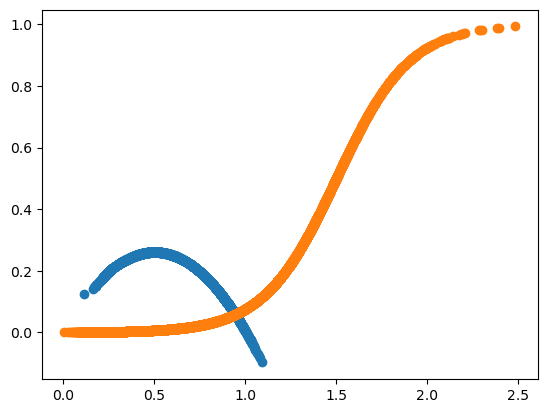

In [12]:
plt.scatter(Mx(My(TensOps(pretrained_pgnniv(X_train)[0], space_dimension=2, contravariance=0, covariance=0))).values.cpu().detach().numpy().flatten(), 
            pretrained_pgnniv(X_train)[1].cpu().detach().numpy().flatten())

plt.scatter(y_train.values.cpu().detach().numpy().flatten(), 
           K_train.values.cpu().detach().numpy().flatten())

In [13]:
pgnniv_pretrained_encoder = pretrained_pgnniv.encoder
pgnniv_pretrained_decoder = pretrained_pgnniv.decoder
pgnniv_pretrained_exp = pretrained_pgnniv.explanatory

for param in pgnniv_pretrained_encoder.parameters():
    param.requires_grad = False

for param in pgnniv_pretrained_decoder.parameters():
    param.requires_grad = True

for param in pgnniv_pretrained_exp.parameters():
    param.requires_grad = True

In [14]:
import torch.nn as nn
import math

def reinitialize_model(model):
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            # Reinitialize Conv2d weights and biases
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            # Reinitialize Linear weights and biases
            nn.init.kaiming_uniform_(module.weight, a=math.sqrt(5))
            if module.bias is not None:
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(module.weight)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(module.bias, -bound, bound)
        elif isinstance(module, nn.BatchNorm2d):
            # Reinitialize BatchNorm layers
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

# reinitialize_model(pgnniv_pretrained_decoder)
# reinitialize_model(pgnniv_pretrained_exp)

In [15]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [16]:
# model = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
params_to_update = filter(lambda p: p.requires_grad, pretrained_pgnniv.parameters())
optimizer = torch.optim.Adam(params_to_update, lr=3e-4)

# Parametros de entrenamiento
start_epoch = 0
n_epochs = 100000

batch_size = 64
n_checkpoints = 5

train_loop(pretrained_pgnniv, optimizer, X_train, y_train, f_train, X_test, y_test, f_test,
           D, n_checkpoints, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
           model_results_path=MODEL_RESULTS_TRANSFERLEARNING_PATH, device=DEVICE)

Starting training from scratch.
Epoch 0, Train loss: 2.900e+08, Test loss: 4.963e+08, MSE(e): 2.896e+01, MSE(pi1): 2.193e+01, MSE(pi2): 1.262e+01, MSE(pi3): 1.571e+00
Epoch 100, Train loss: 2.325e+08, Test loss: 3.933e+08, MSE(e): 2.321e+01, MSE(pi1): 2.336e+01, MSE(pi2): 1.014e+01, MSE(pi3): 1.630e+00
Epoch 200, Train loss: 1.967e+08, Test loss: 3.205e+08, MSE(e): 1.962e+01, MSE(pi1): 2.500e+01, MSE(pi2): 8.505e+00, MSE(pi3): 1.693e+00
Epoch 300, Train loss: 1.743e+08, Test loss: 2.736e+08, MSE(e): 1.739e+01, MSE(pi1): 2.566e+01, MSE(pi2): 7.455e+00, MSE(pi3): 1.727e+00
Epoch 400, Train loss: 1.588e+08, Test loss: 2.425e+08, MSE(e): 1.584e+01, MSE(pi1): 2.524e+01, MSE(pi2): 6.738e+00, MSE(pi3): 1.718e+00
Epoch 500, Train loss: 1.468e+08, Test loss: 2.199e+08, MSE(e): 1.463e+01, MSE(pi1): 2.431e+01, MSE(pi2): 6.198e+00, MSE(pi3): 1.674e+00
Epoch 600, Train loss: 1.368e+08, Test loss: 2.020e+08, MSE(e): 1.364e+01, MSE(pi1): 2.325e+01, MSE(pi2): 5.761e+00, MSE(pi3): 1.597e+00
Epoch 700, 

In [17]:
# start_epoch = n_epochs-1
# n_epochs = 20000

# batch_size = 64 
# n_checkpoints = 5

# second_lr = 3e-4

# train_loop(pretrained_pgnniv, optimizer, X_train, y_train, f_train, X_test, y_test, f_test,
#            D, n_checkpoints, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
#            model_results_path=MODEL_RESULTS_TRANSFERLEARNING_PATH, device=DEVICE)

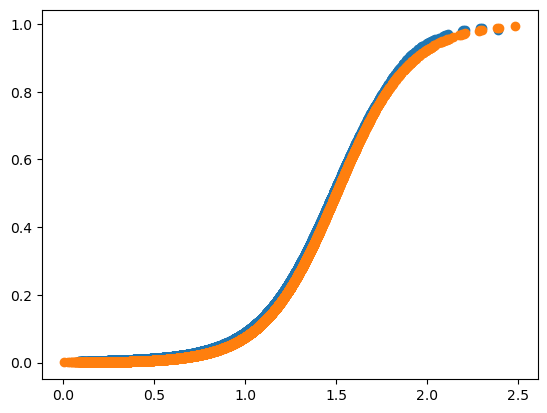

: 

In [ ]:
plt.scatter(Mx(My(TensOps(pretrained_pgnniv(X_train)[0], space_dimension=2, contravariance=0, covariance=0))).values.cpu().detach().numpy().flatten(), 
            pretrained_pgnniv(X_train)[1].cpu().detach().numpy().flatten())

plt.scatter(y_train.values.cpu().detach().numpy().flatten(), 
           K_train.values.cpu().detach().numpy().flatten())